In [1]:
import pandas as pd
import yake
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import tldextract
import pycountry
import pycountry_convert as pc
import ast
from utils import *

In [2]:
data_transformers = pd.read_csv('/content/data_processed_transformers.csv')
data_transformers.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,normalized_title,clean_title,subdomain,domain_root,tld,Disaster_Event,Location
0,https://www.wpri.com/weather/severe-weather/20...,https://www.wpri.com/weather/severe-weather/20...,2023 was a year of extreme weather in Southern...,20240101T223000Z,https://www.wpri.com/wp-content/uploads/sites/...,wpri.com,English,United States,2023 was a year of extreme weather in Southern...,2023 was a year of extreme weather in Southern...,NaN,wpri,com,NaN,NaN
1,https://volcanoes.usgs.gov/hans2/view/notice/D...,NaN,HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Mond...,20240101T220000Z,NaN,volcanoes.usgs.gov,English,United States,HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Mond...,HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Mond...,volcanoes,usgs,gov,NaN,NaN
2,https://www.ktbs.com/online_features/home_impr...,NaN,How to Protect Your Family from Tornadoes,20240101T124500Z,https://bloximages.newyork1.vip.townnews.com/k...,ktbs.com,English,United States,How to Protect Your Family from Tornadoes,How to Protect Your Family from Tornadoes,NaN,ktbs,com,Tornado,NaN
3,https://www.ctvnews.ca/climate-and-environment...,NaN,Iceland volcanoes bring tourists to island cou...,20240101T223000Z,https://www.ctvnews.ca/content/dam/ctvnews/en/...,ctvnews.ca,English,Canada,Iceland volcanoes bring tourists to island cou...,Iceland volcanoes bring tourists to island cou...,NaN,ctvnews,ca,NaN,NaN
4,https://news.yahoo.com/tornados-scorchers-ice-...,NaN,"Tornados , scorchers and ice storm : Top 10 we...",20240101T131500Z,https://s.yimg.com/ny/api/res/1.2/PXdWVXp40q9s...,news.yahoo.com,English,United States,"Tornados , scorchers and ice storm : Top 10 we...","Tornados , scorchers and ice storm : Top 10 we...",news,yahoo,com,Tornado,"A, ##bilene, San Angelo"


In [3]:
data_transformers.shape

(64967, 15)

In [4]:
data_transformers['seendate'] = pd.to_datetime(data_transformers['seendate'], format='%Y%m%dT%H%M%SZ', errors='coerce')

In [5]:
# filtering where we have a disaster event and location
filtered_transformers_data = data_transformers[data_transformers['Disaster_Event'].notna() & data_transformers['Location'].notna()]
filtered_transformers_data.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,normalized_title,clean_title,subdomain,domain_root,tld,Disaster_Event,Location
4,https://news.yahoo.com/tornados-scorchers-ice-...,NaN,"Tornados , scorchers and ice storm : Top 10 we...",2024-01-01 13:15:00,https://s.yimg.com/ny/api/res/1.2/PXdWVXp40q9s...,news.yahoo.com,English,United States,"Tornados , scorchers and ice storm : Top 10 we...","Tornados , scorchers and ice storm : Top 10 we...",news,yahoo,com,Tornado,"A, ##bilene, San Angelo"
12,https://globalnews.ca/news/10198334/japan-eart...,https://globalnews.ca/news/10198334/japan-eart...,Japan earthquakes : Coastal residents told to ...,2024-01-01 16:15:00,https://globalnews.ca/wp-content/uploads/2024/...,globalnews.ca,English,Canada,Japan earthquakes : Coastal residents told to ...,Japan earthquakes : Coastal residents told to ...,NaN,globalnews,ca,Earthquake,Japan
16,https://reliefweb.int/report/philippines/dswd-...,NaN,DSWD DROMIC Report on the Tornado Incident in ...,2024-01-01 09:30:00,https://reliefweb.int/sites/default/files/styl...,reliefweb.int,English,Syria,DSWD DROMIC Report on the Tornado Incident in ...,DSWD DROMIC Report on the Tornado Incident in ...,NaN,reliefweb,int,Tornado,"B, ##rgy. Rizal, Anao, Tarlac, Philippines"
18,https://www.islandpacket.com/news/nation-world...,NaN,Winter Weather Alerts Issued for Multiple Stat...,2024-01-01 16:15:00,https://www.mcclatchy-wires.com/incoming/uk777...,islandpacket.com,English,United States,Winter Weather Alerts Issued for Multiple Stat...,Winter Weather Alerts Issued for Multiple Stat...,NaN,islandpacket,com,Tornado,States
19,https://www.columbian.com/news/2023/dec/31/new...,NaN,New state report : Wildfire smoke increased de...,2024-01-01 05:30:00,https://pcdn.columbian.com/wp-content/themes/c...,columbian.com,English,United States,New state report : Wildfire smoke increased de...,New state report : Wildfire smoke increased de...,NaN,columbian,com,Wildfire,"Spokane, Washington"


In [6]:
# data shape after filtering droped from 64976 to 23634
filtered_transformers_data.shape

(23634, 15)

In [7]:
data = filtered_transformers_data.copy()

# Extracting key words from title


In [8]:
# YAKE keyword extractor
kw_extractor = yake.KeywordExtractor(
    lan="en",       # Language
    n=1,            # Max number of words per keyword (can set to 2 or 3 if you want phrases)
    dedupLim=0.9,   # How similar keywords can be before deduplication
    top=5,          # How many keywords to extract
    features=None   # Use default features
)

# Extract keywords from each title
def extract_keywords(text):
    keywords = kw_extractor.extract_keywords(text)
    return [kw for kw, score in keywords]  # Just return keyword strings
data['keywords'] = data['clean_title'].apply(extract_keywords)

In [9]:
data.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,normalized_title,clean_title,subdomain,domain_root,tld,Disaster_Event,Location,keywords
4,https://news.yahoo.com/tornados-scorchers-ice-...,NaN,"Tornados , scorchers and ice storm : Top 10 we...",2024-01-01 13:15:00,https://s.yimg.com/ny/api/res/1.2/PXdWVXp40q9s...,news.yahoo.com,English,United States,"Tornados , scorchers and ice storm : Top 10 we...","Tornados , scorchers and ice storm : Top 10 we...",news,yahoo,com,Tornado,"A, ##bilene, San Angelo","[Top, Tornados, Abilene, San, Angelo]"
12,https://globalnews.ca/news/10198334/japan-eart...,https://globalnews.ca/news/10198334/japan-eart...,Japan earthquakes : Coastal residents told to ...,2024-01-01 16:15:00,https://globalnews.ca/wp-content/uploads/2024/...,globalnews.ca,English,Canada,Japan earthquakes : Coastal residents told to ...,Japan earthquakes : Coastal residents told to ...,NaN,globalnews,ca,Earthquake,Japan,"[National, Coastal, Japan, earthquakes, warnings]"
16,https://reliefweb.int/report/philippines/dswd-...,NaN,DSWD DROMIC Report on the Tornado Incident in ...,2024-01-01 09:30:00,https://reliefweb.int/sites/default/files/styl...,reliefweb.int,English,Syria,DSWD DROMIC Report on the Tornado Incident in ...,DSWD DROMIC Report on the Tornado Incident in ...,NaN,reliefweb,int,Tornado,"B, ##rgy. Rizal, Anao, Tarlac, Philippines","[Rizal, Anao, Tarlac, December, Philippines]"
18,https://www.islandpacket.com/news/nation-world...,NaN,Winter Weather Alerts Issued for Multiple Stat...,2024-01-01 16:15:00,https://www.mcclatchy-wires.com/incoming/uk777...,islandpacket.com,English,United States,Winter Weather Alerts Issued for Multiple Stat...,Winter Weather Alerts Issued for Multiple Stat...,NaN,islandpacket,com,Tornado,States,"[Forms, Weather, Alerts, Issued, Multiple]"
19,https://www.columbian.com/news/2023/dec/31/new...,NaN,New state report : Wildfire smoke increased de...,2024-01-01 05:30:00,https://pcdn.columbian.com/wp-content/themes/c...,columbian.com,English,United States,New state report : Wildfire smoke increased de...,New state report : Wildfire smoke increased de...,NaN,columbian,com,Wildfire,"Spokane, Washington","[Wildfire, Spokane, Washington, report, state]"


# Feature engineering for Seen Date column

In [10]:
# instead of date column will represent it by month and season
data['seendate'] = pd.to_datetime(data['seendate'], errors='coerce')
data['month'] = data['seendate'].dt.month
data['season'] = data['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

In [11]:
data['month'].value_counts()

,count
month,
7,2344
5,2195
6,2194
8,2112
9,2073
10,1986
12,1950
4,1950
11,1897


It can be seen that the most popular month is July, and summer months + may in general. Overall, there are no significant difference across all months

# Feature Engineering for locations

In [12]:
# these functions are extracted from utils
data['country_extracted'] = data['Location'].apply(get_country_from_text)
data['continent'] = data['country_extracted'].apply(get_continent)

In [13]:
data['continent'].value_counts()

,count
continent,
Unknown,18371
Asia,2194
North America,1350
Europe,639
Oceania,414
South America,342
Africa,324


In [14]:
data.shape

(23634, 20)

In [15]:
# I won't select all columns for clustering.
# Will not keep columns that contain too many missing values and columns that would have high correlations
selected_cols = [
    'Disaster_Event', 'keywords',
    'month', 'season', 'country_extracted']
df_cluster = data[selected_cols].copy()
df_cluster.head()

,Disaster_Event,keywords,month,season,country_extracted
4,Tornado,"[Top, Tornados, Abilene, San, Angelo]",1,Winter,None
12,Earthquake,"[National, Coastal, Japan, earthquakes, warnings]",1,Winter,Japan
16,Tornado,"[Rizal, Anao, Tarlac, December, Philippines]",1,Winter,Philippines
18,Tornado,"[Forms, Weather, Alerts, Issued, Multiple]",1,Winter,None
19,Wildfire,"[Wildfire, Spokane, Washington, report, state]",1,Winter,None


In [16]:
df_cluster['Disaster_Event'].value_counts()

,count
Disaster_Event,
Earthquake,6744
Flood,5973
Tornado,4740
Wildfire,4620
Hurricane,707
Eruption,472
Tsunami,242
Volcanic Eruption,136


In [17]:
df_cluster = df_cluster[~df_cluster['Disaster_Event'].isin(['Tsunami', 'Hurricane'])]

# Merge 'Eruption' and 'Volcanic Eruption' into 'Volcano'
df_cluster['Disaster_Event'] = df_cluster['Disaster_Event'].replace({
    'Eruption': 'Volcano',
    'Volcanic Eruption': 'Volcano'
})

#Preview final class counts
print("Final Disaster Category Counts:")
print(df_cluster['Disaster_Event'].value_counts())

Final Disaster Category Counts:
Disaster_Event
Earthquake    6744
Flood         5973
Tornado       4740
Wildfire      4620
Volcano        608
Name: count, dtype: int64


<ipython-input-17-9479b515ca1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Disaster_Event'] = df_cluster['Disaster_Event'].replace({


Most of the disaster event types have the same number of representations, except Volcano events which are missrepresented

In [18]:
df_cluster['country_extracted'].value_counts()

,count
country_extracted,
United States,680
Japan,542
Indonesia,388
Canada,313
Philippines,176
...,...
Réunion,1
Botswana,1
Mali,1


In [19]:
# Normalize null-like entries
df_cluster.replace({'None': np.nan, 'none': np.nan, 'Unknown': np.nan}, inplace=True)

# Clean and fill missing values
for col in ['month', 'season', 'country_extracted' ]:
    df_cluster[col] = df_cluster[col].astype(str).fillna('missing').str.lower().str.strip()

    # Replace "nan" strings introduced by astype(str)
    df_cluster[col] = df_cluster[col].replace('nan', 'missing')

In [20]:
df_cluster['keywords_str'] = df_cluster['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

In [21]:
df_cluster

,Disaster_Event,keywords,month,season,country_extracted,keywords_str
4,Tornado,"[Top, Tornados, Abilene, San, Angelo]",1,winter,none,Top Tornados Abilene San Angelo
12,Earthquake,"[National, Coastal, Japan, earthquakes, warnings]",1,winter,japan,National Coastal Japan earthquakes warnings
16,Tornado,"[Rizal, Anao, Tarlac, December, Philippines]",1,winter,philippines,Rizal Anao Tarlac December Philippines
18,Tornado,"[Forms, Weather, Alerts, Issued, Multiple]",1,winter,none,Forms Weather Alerts Issued Multiple
19,Wildfire,"[Wildfire, Spokane, Washington, report, state]",1,winter,none,Wildfire Spokane Washington report state
...,...,...,...,...,...,...
64934,Tornado,"[tornado, County, Montgomery, leaders, secure]",12,winter,none,tornado County Montgomery leaders secure
64949,Flood,"[Floods, Johor, Kelantan, situation, evacuated]",12,winter,none,Floods Johor Kelantan situation evacuated
64950,Flood,"[Sri, Alam, Tmn, compensation, folk]",12,winter,none,Sri Alam Tmn compensation folk
64960,Flood,"[Coast, North, week, braces, potential]",12,winter,none,Coast North week braces potential


In [22]:
df_cluster['season'].value_counts()

,count
season,
summer,6483
spring,5671
autumn,5441
winter,5090


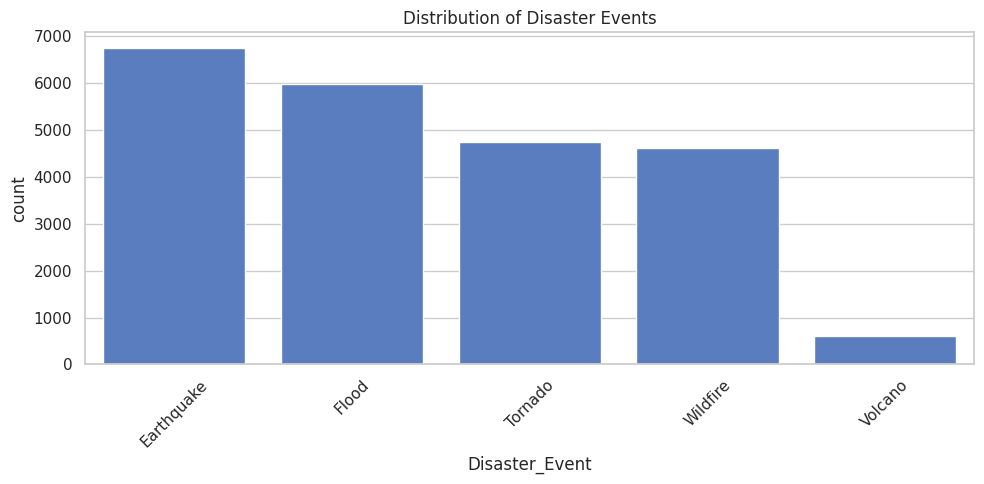

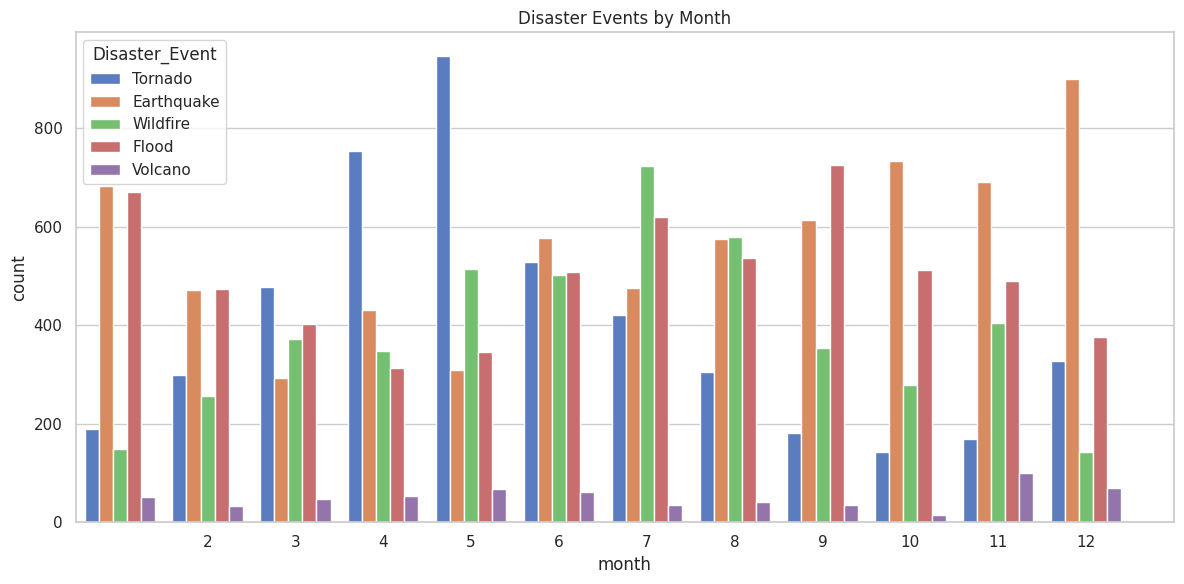

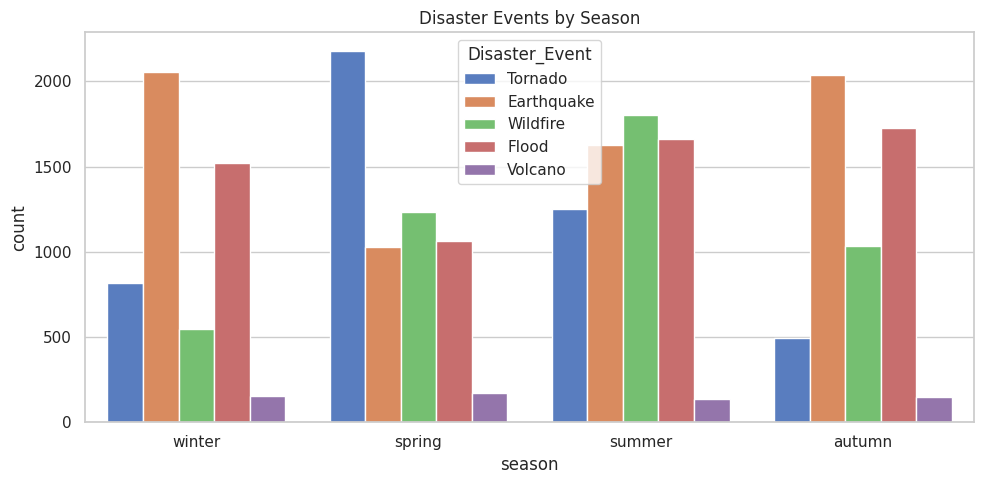

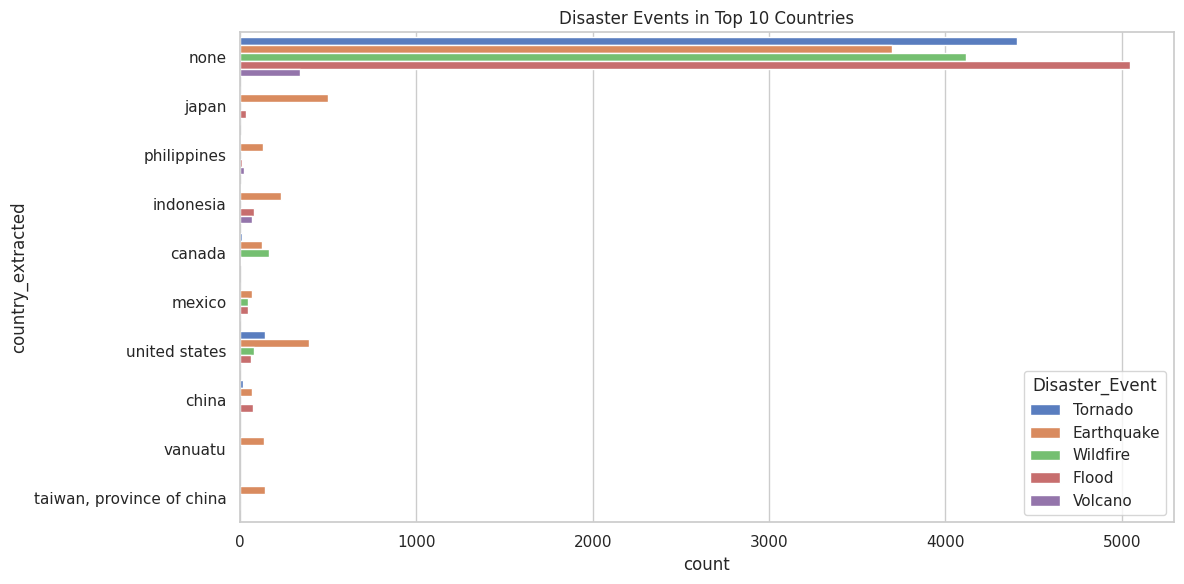

In [25]:
# Ensure you're using a clean copy of your data
df = df_cluster.copy()
df['country_extracted'] = df['country_extracted'].fillna('unknown')

sns.set(style="whitegrid", palette="muted")

# 1. Disaster_Event count
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Disaster_Event', order=df['Disaster_Event'].value_counts().index)
plt.title("Distribution of Disaster Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Disaster_Event by Month
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='month', hue='Disaster_Event')
plt.title("Disaster Events by Month")
plt.xticks(range(1, 13))
plt.legend(title='Disaster_Event')
plt.tight_layout()
plt.show()

# Disaster_Event by Season
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='season', hue='Disaster_Event', order=['winter', 'spring', 'summer', 'autumn'])
plt.title("Disaster Events by Season")
plt.tight_layout()
plt.show()

# Top 10 countries by Disaster Event frequency
top_countries = df['country_extracted'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['country_extracted'].isin(top_countries)], y='country_extracted', hue='Disaster_Event')
plt.title("Disaster Events in Top 10 Countries")
plt.tight_layout()
plt.show()

# Encoding and Clustering


In [24]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

# Load model (use a small one if performance is an issue)
model = SentenceTransformer('all-MiniLM-L6-v2')

df = df_cluster.copy()  # assuming you already have this
df['country_extracted'] = df['country_extracted'].fillna('unknown')

# Embed the keywords_str
print("Embedding keywords...")
keyword_embeddings = model.encode(df['keywords_str'].tolist(), show_progress_bar=True)

# Encode categorical features
cat_features = ['Disaster_Event', 'season', 'country_extracted']
encoder = OrdinalEncoder()
cat_encoded = encoder.fit_transform(df[cat_features])

# Scale numerical features
scaler = StandardScaler()
month_scaled = scaler.fit_transform(df[['month']])

# Combine all features
X = np.hstack([keyword_embeddings, cat_encoded, month_scaled])

# Clustering comparison
def run_clustering(X):
    results = {}

    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    results['KMeans'] = {
        'model': kmeans,
        'labels': kmeans_labels,
        'silhouette': silhouette_score(X, kmeans_labels)
    }

    dbscan = DBSCAN(eps=1.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    dbscan_score = silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
    results['DBSCAN'] = {
        'model': dbscan,
        'labels': dbscan_labels,
        'silhouette': dbscan_score
    }

    agg = AgglomerativeClustering(n_clusters=5)
    agg_labels = agg.fit_predict(X)
    results['Agglomerative'] = {
        'model': agg,
        'labels': agg_labels,
        'silhouette': silhouette_score(X, agg_labels)
    }

    return results

# Run and compare
results = run_clustering(X)

# Print comparison
for name, res in results.items():
    print(f"{name} Silhouette Score: {res['silhouette']:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding keywords...


Batches:   0%|          | 0/709 [00:00<?, ?it/s]

KMeans Silhouette Score: 0.8527
DBSCAN Silhouette Score: 0.2333
Agglomerative Silhouette Score: 0.8344


In [26]:
# Will be working and improving KMeans Clustering as it got the highest score of 85%
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples
)
from sklearn.decomposition import PCA

# Fit KMeans
kmeans = KMeans(
    n_clusters=5,
    n_init=20,
    max_iter=500,
    random_state=42,
    verbose=0
)
df['cluster'] = kmeans.fit_predict(X)

# Evaluation metrics
sil_score = silhouette_score(X, df['cluster'])
calinski_score = calinski_harabasz_score(X, df['cluster'])
davies_score = davies_bouldin_score(X, df['cluster'])

print(f"KMeans Silhouette Score: {sil_score:.4f}")
print(f"Calinski-Harabasz Index: {calinski_score:.2f}")
print(f"Davies-Bouldin Index: {davies_score:.4f}")

KMeans Silhouette Score: 0.8527
Calinski-Harabasz Index: 178690.17
Davies-Bouldin Index: 0.3492


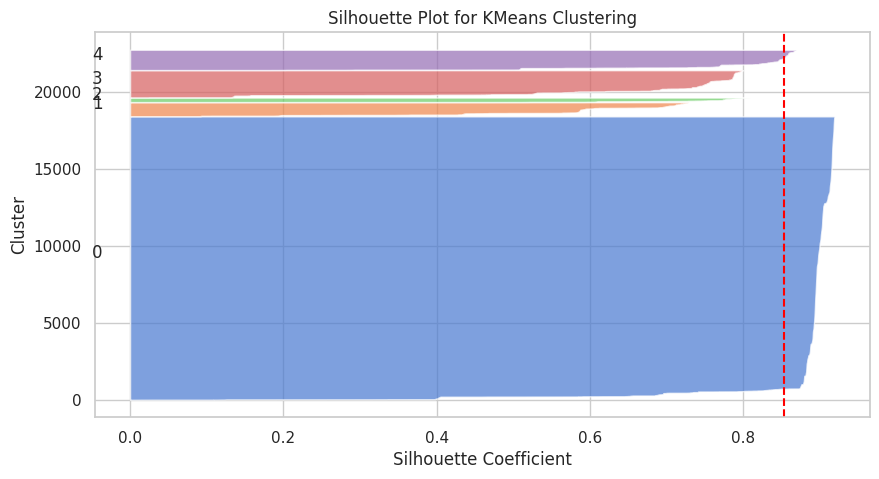

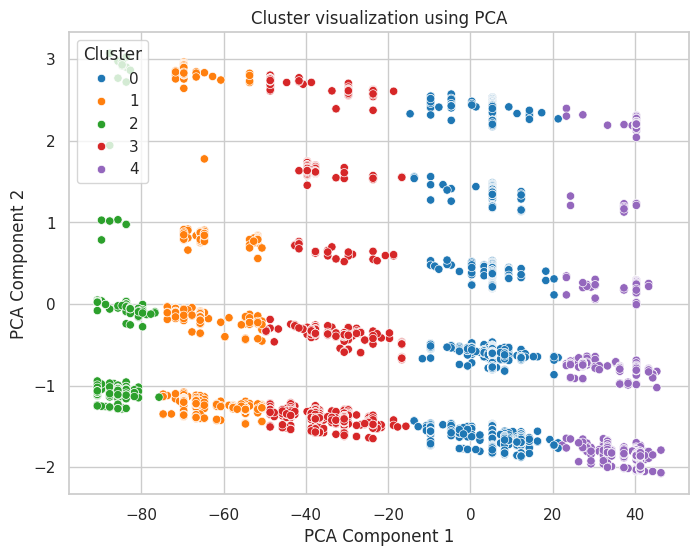

<ipython-input-27-8bc1bf283e5a>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='tab10')


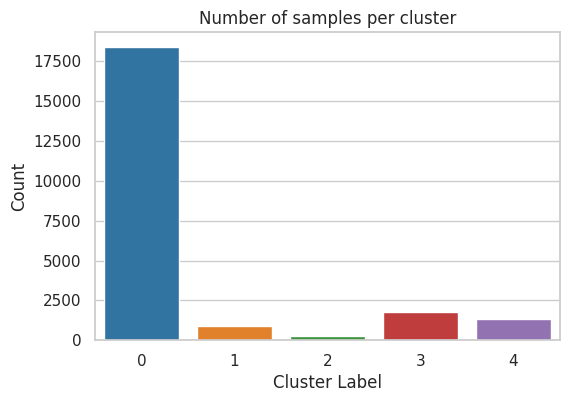

In [27]:
# Visualisations of the results
# Silhouette plot
sample_silhouette_values = silhouette_samples(X, df['cluster'])
y_lower = 10
plt.figure(figsize=(10, 5))
for i in range(5):
    ith_silhouette_values = sample_silhouette_values[df['cluster'] == i]
    ith_silhouette_values.sort()
    size_cluster_i = ith_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.axvline(x=sil_score, color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for KMeans Clustering")
plt.show()

# Cluster visualization (using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='tab10')
plt.title("Cluster visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Count of points per cluster
plt.figure(figsize=(6, 4))
sns.countplot(x='cluster', data=df, palette='tab10')
plt.title("Number of samples per cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()

This silhouette plot shows that most data points fall into one dominant cluster (Cluster 0) with relatively high silhouette scores (close to 0.85), while the remaining clusters are much smaller and less consistent. The narrow width and lower scores of clusters 1–4 suggest overclustering or imbalance, with possibly unclear separation. Overall, KMeans found one strong cluster, but others might be weak or noisy. Reducing the number of clusters or trying a density-based method like DBSCAN may improve performance. I will be removing high-dimensional or noisy features (like keyword embeddings or high-cardinality columns such as country_extracted) can sometimes improve cluster separation and reduce overfitting to noise.
Also data was imbalanced where some of the Disaster Events like Volcano had less examples than leading Earthquake Event. So I will be downsampling.

In [42]:
from sklearn.utils import resample

# Target class distribution
min_size = df_cluster['Disaster_Event'].value_counts().min()

# Create a balanced dataset
balanced_df = pd.concat([
    resample(df_cluster[df_cluster['Disaster_Event'] == keyword],
             replace=False,
             n_samples=min_size,
             random_state=42)
    for keyword in df_cluster['Disaster_Event'].unique()
])
print(balanced_df.shape)
balanced_df.head()

(3040, 6)


,Disaster_Event,keywords,month,season,country_extracted,keywords_str
24742,Tornado,"[Iowa, Tornado, leaves, multiple, fatalities]",5,spring,none,Iowa Tornado leaves multiple fatalities
8817,Tornado,"[Monday, Level, Area, Bay, thunderstorms]",2,winter,none,Monday Level Area Bay thunderstorms
19609,Tornado,"[Illinois, Weather, Service, National, confirms]",4,spring,none,Illinois Weather Service National confirms
22108,Tornado,"[Tornado, northwestern, watch, issued, parts]",5,spring,macao,Tornado northwestern watch issued parts
27284,Tornado,"[Ohio, set, years, ago, ties]",6,summer,none,Ohio set years ago ties


In [45]:
df = balanced_df.copy()
df = df.drop(columns=['keywords', 'country_extracted', 'keywords_str'])
# Encode categorical features
cat_features = ['Disaster_Event', 'season']
encoder = OrdinalEncoder()
cat_encoded = encoder.fit_transform(df[cat_features])

# Scale numerical features
scaler = StandardScaler()
month_scaled = scaler.fit_transform(df[['month']])

# Combine all features
X = np.hstack([cat_encoded, month_scaled])

In [46]:
# Fit KMeans
kmeans = KMeans(
    n_clusters=5,
    n_init=20,
    max_iter=500,
    random_state=42,
    verbose=0
)
df['cluster'] = kmeans.fit_predict(X)

# Evaluation metrics
sil_score = silhouette_score(X, df['cluster'])
calinski_score = calinski_harabasz_score(X, df['cluster'])
davies_score = davies_bouldin_score(X, df['cluster'])

print(f"KMeans Silhouette Score: {sil_score:.4f}")
print(f"Calinski-Harabasz Index: {calinski_score:.2f}")
print(f"Davies-Bouldin Index: {davies_score:.4f}")

KMeans Silhouette Score: 0.3954
Calinski-Harabasz Index: 1651.25
Davies-Bouldin Index: 1.0109


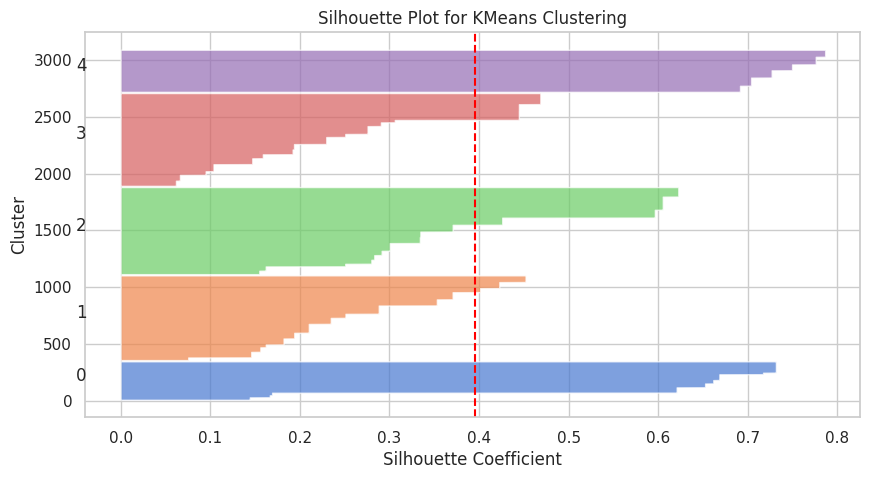

Cluster 0:
 - Most common keyword: Volcano
 - Size: 339

Cluster 1:
 - Most common keyword: Earthquake
 - Size: 746

Cluster 2:
 - Most common keyword: Tornado
 - Size: 767

Cluster 3:
 - Most common keyword: Wildfire
 - Size: 817

Cluster 4:
 - Most common keyword: Flood
 - Size: 371



In [47]:
# Visualisations of the results
# Silhouette plot
sample_silhouette_values = silhouette_samples(X, df['cluster'])
y_lower = 10
plt.figure(figsize=(10, 5))
for i in range(5):
    ith_silhouette_values = sample_silhouette_values[df['cluster'] == i]
    ith_silhouette_values.sort()
    size_cluster_i = ith_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.axvline(x=sil_score, color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for KMeans Clustering")
plt.show()

# Predictive-Like Description: Top keywords/countries per cluster
for i in range(5):
    cluster_data = df[df['cluster'] == i]
    common_keyword = cluster_data['Disaster_Event'].mode()[0]
    print(f"Cluster {i}:")
    print(f" - Most common keyword: {common_keyword}")
    print(f" - Size: {len(cluster_data)}")
    print()

After initial clustering with all features included, a dominant cluster emerged (Cluster 0) with a high silhouette score (~0.85), while the rest showed lower cohesion and possible overclustering; this imbalance was traced to overrepresented disaster types like Earthquake (6744 samples vs. only 608 for Volcano), leading to a downsampling step where each event category was balanced to improve fairness. Following this, high-cardinality or noisy features such as country_extracted and keyword embeddings were removed, and the clustering was rerun; although the silhouette scores dropped to around 0.4, the resulting clusters were more balanced, interpretable, and aligned better with real-world disaster categories—indicating a trade-off between numerical cohesion and semantic clarity, ultimately leading to more meaningful segmentation of disaster-related news data.